# Importing Required Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

# arrays and dataframes
import pandas as pd
import numpy as np

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

#stat
# time series- statsmodels
from statsmodels import robust
from statsmodels.tsa.filters.hp_filter import hpfilter  # Hodrick Prescott filter for cyclic & trend separation
from statsmodels.tsa.seasonal import seasonal_decompose # Error Trend Seasonality decomposition

# holt winters 
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   # single exponential smoothing as in ewm of pandas
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing

# Evaluation Metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error

## Dataset 

* Daily Climate time series data - https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data
* This dataset provides data from 1st January 2013 to 24th April 2017 in the city of Delhi, India.
* The 4 parameters here are - meantemp, humidity, wind_speed, meanpressure.

In [2]:
weather1 = pd.read_csv("CSV Files/DailyDelhiClimateTrain.csv", parse_dates = True, low_memory = False)
weather2 = pd.read_csv("CSV Files/DailyDelhiClimateTest.csv", parse_dates = True, low_memory = False)
weather = pd.concat([weather1, weather2], axis = 0)

In [3]:
weather.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [4]:
weather.tail()

,date,meantemp,humidity,wind_speed,meanpressure
109,2017-04-20,34.500,27.500000,5.562500,998.625000
110,2017-04-21,34.250,39.375000,6.962500,999.875000
111,2017-04-22,32.900,40.900000,8.890000,1001.600000
112,2017-04-23,32.875,27.500000,9.962500,1002.125000
113,2017-04-24,32.000,27.142857,12.157143,1004.142857


In [5]:
weather.describe

<bound method NDFrame.describe of            date   meantemp   humidity  wind_speed  meanpressure
0    2013-01-01  10.000000  84.500000    0.000000   1015.666667
1    2013-01-02   7.400000  92.000000    2.980000   1017.800000
2    2013-01-03   7.166667  87.000000    4.633333   1018.666667
3    2013-01-04   8.666667  71.333333    1.233333   1017.166667
4    2013-01-05   6.000000  86.833333    3.700000   1016.500000
..          ...        ...        ...         ...           ...
109  2017-04-20  34.500000  27.500000    5.562500    998.625000
110  2017-04-21  34.250000  39.375000    6.962500    999.875000
111  2017-04-22  32.900000  40.900000    8.890000   1001.600000
112  2017-04-23  32.875000  27.500000    9.962500   1002.125000
113  2017-04-24  32.000000  27.142857   12.157143   1004.142857

[1576 rows x 5 columns]>

In [6]:
weather.info

<bound method DataFrame.info of            date   meantemp   humidity  wind_speed  meanpressure
0    2013-01-01  10.000000  84.500000    0.000000   1015.666667
1    2013-01-02   7.400000  92.000000    2.980000   1017.800000
2    2013-01-03   7.166667  87.000000    4.633333   1018.666667
3    2013-01-04   8.666667  71.333333    1.233333   1017.166667
4    2013-01-05   6.000000  86.833333    3.700000   1016.500000
..          ...        ...        ...         ...           ...
109  2017-04-20  34.500000  27.500000    5.562500    998.625000
110  2017-04-21  34.250000  39.375000    6.962500    999.875000
111  2017-04-22  32.900000  40.900000    8.890000   1001.600000
112  2017-04-23  32.875000  27.500000    9.962500   1002.125000
113  2017-04-24  32.000000  27.142857   12.157143   1004.142857

[1576 rows x 5 columns]>

In [7]:
weather.shape

(1576, 5)

In [8]:
weather.columns

Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')

In [9]:
weather['date'].unique

<bound method Series.unique of 0      2013-01-01
1      2013-01-02
2      2013-01-03
3      2013-01-04
4      2013-01-05
          ...    
109    2017-04-20
110    2017-04-21
111    2017-04-22
112    2017-04-23
113    2017-04-24
Name: date, Length: 1576, dtype: object>

In [10]:
weather['date'].value_counts

<bound method IndexOpsMixin.value_counts of 0      2013-01-01
1      2013-01-02
2      2013-01-03
3      2013-01-04
4      2013-01-05
          ...    
109    2017-04-20
110    2017-04-21
111    2017-04-22
112    2017-04-23
113    2017-04-24
Name: date, Length: 1576, dtype: object>

#### Observations
* There are 1461 dates with different values present in the data
* There are 4 columns in the date - ['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure']

# Smoothing & Holt Winters Forecast

## Introduction

* Hodrick Prescott filter to separate the trend and cyclic components
* Error, Trend and Seasonality Decomposition using Statsmodels Seasonal Decomposition
* Exponential Smoothing using Pandas EWMA and Holt Winters method for Single, Double and Triple Exponential Smoothing
* Forecast into the real future using Holt Winters triple exponential method

## Part I - Time Series Decomposition

### Hodrick Prescott Filter

The Hodrick Prescott filter is used to separate the trend and cyclical component from the time series data. The components are determined by minimising the quadratic loss function where an important element is lambda which is the smoothing parameter. The recommended value of lambda is 1600 when analyzing quarterly data, 6.25 for yearly data and 129,600 for monthly data. Removing the cyclic component essentially, makes the data sensitive to long term fluctuations and not to the short term fluctuations. This is especially important for analyzing the GDP.

Read more about Hodrick Prescott filter here https://en.wikipedia.org/wiki/Hodrick%E2%80%93Prescott_filter#:~:text=The%20Hodrick%E2%80%93Prescott%20filter%20(also,time%20series%20from%20raw%20data.

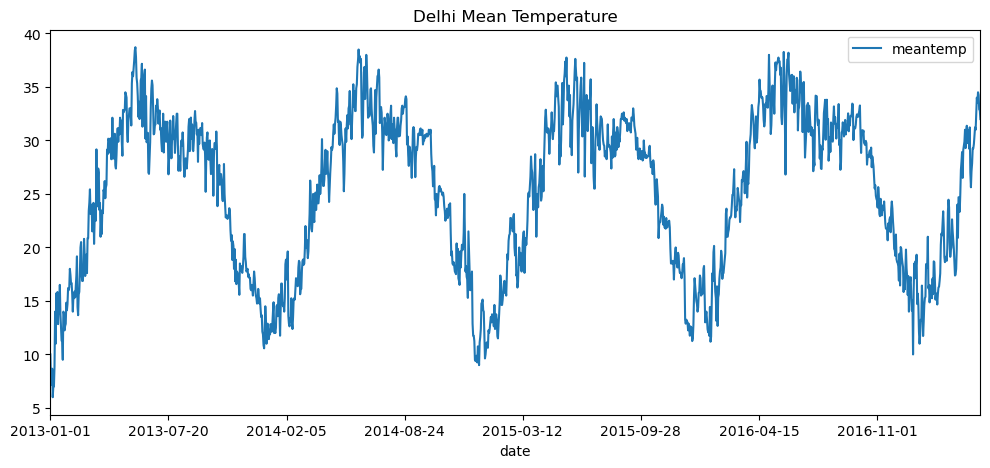

In [11]:
# visualize the Temperature --- > will use the capabilities of pandas plotting capability
weather.plot(figsize=(12,5),title='Delhi Mean Temperature', x='date', y='meantemp').autoscale(axis='x',tight=True)

* The trend and cycles can be separated using tuple unpacking

In [12]:
# tuple unpacking, lambda as 1600 to analyze the quarterly trend 
cycles,trend = hpfilter(weather['meantemp'],lamb=1600) 

* Trend as an additional column in the data frame will be added which makes plotting easier with pandas

In [13]:
weather['meantemp_trend'] = trend
weather['meantemp_cycles'] = cycles

In [14]:
weather.head()

,date,meantemp,humidity,wind_speed,meanpressure,meantemp_trend,meantemp_cycles
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,7.786509,2.213491
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,8.165925,-0.765925
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,8.546724,-1.380057
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,8.929811,-0.263144
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,9.315228,-3.315228


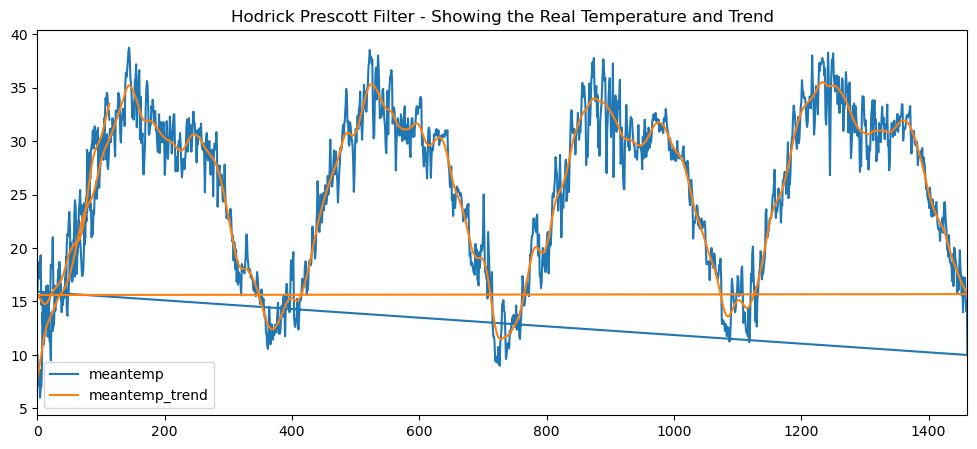

In [15]:
weather[['meantemp','meantemp_trend']].plot(figsize=(12,5),title='Hodrick Prescott Filter - Showing the Real Temperature and Trend').autoscale(axis='x',tight=True)

* Now that the Temperature trend is present which is sensitive to the long term fluctuations and not to the short term fluctuations. This makes more sense for analysing the weather life cycle over a well defined period. Similarly, the trend can be analyzed by varying the values of lambda to check for annual and monthly trend.

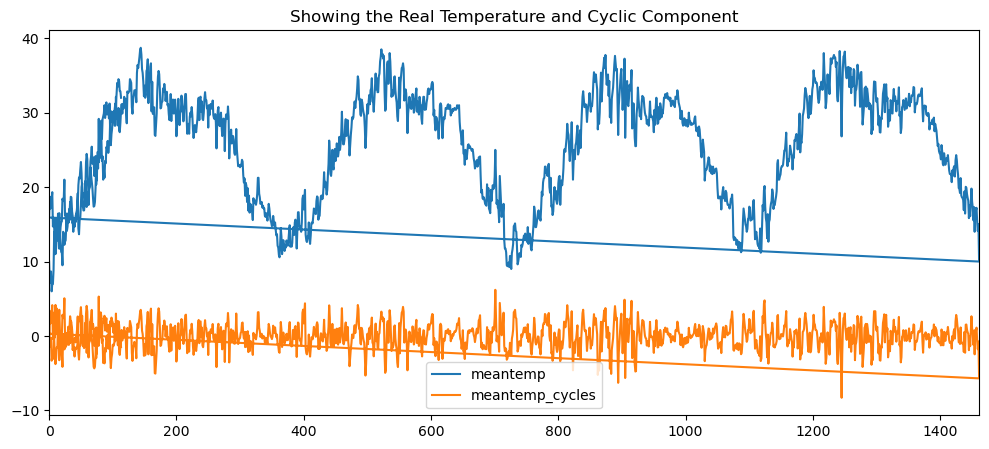

In [16]:
weather[['meantemp','meantemp_cycles']].plot(figsize=(12,5),title='Showing the Real Temperature and Cyclic Component').autoscale(axis='x',tight=True)

* Now, the same analysis should be done since year 2015

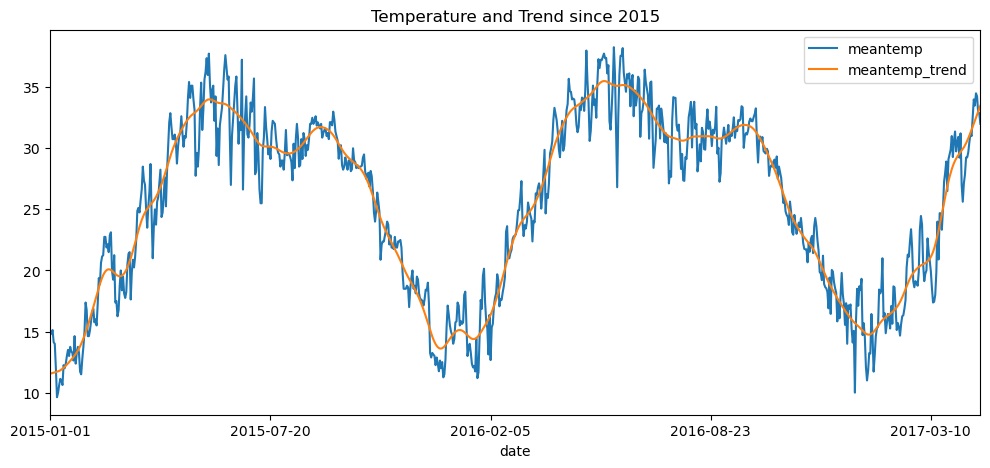

In [17]:
weather.set_index('date', inplace=True)
weather[['meantemp','meantemp_trend']]['2015-01-01':].plot(figsize=(12,5),title='Temperature and Trend since 2015').autoscale(axis='x',tight=True)

#### Observations
* Daily Mean temperature varies between 5 to 40 degree celcius.
* The Mean temperature trend in the data is symmetric.
* The Mean temperature trend is slightly higher than Mean temperature.
* The Mean temperature cycle is significantly lower than Mean temperature.
* The Mean temperature trend from the year 2015 has shown similar attitude as the whole mean temperature trend.

### ETS - Error, Trend and Seasonality Decomposition

The decomposition of a time series attempts to isolate individual components such as error, trend and seasonality. Statsmodels provided seasonal decomposition tool to separate out the different components.The decomposition of a time series attempts to isolate individual components such as error, trend and seasonality. Statsmodels provided seasonal decomposition tool to separate out the different components.

Additive model is used when the trend component is more constant over time. Example, every year mean temperature is increasing by 2 degree.

Multiplicative model is used when the trend increases/decreases at a non linear rate. Example, every year mean temperature is doubling by 2 degree.

In [18]:
weather.head()

,meantemp,humidity,wind_speed,meanpressure,meantemp_trend,meantemp_cycles
date,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,7.786509,2.213491
2013-01-02,7.400000,92.000000,2.980000,1017.800000,8.165925,-0.765925
2013-01-03,7.166667,87.000000,4.633333,1018.666667,8.546724,-1.380057
2013-01-04,8.666667,71.333333,1.233333,1017.166667,8.929811,-0.263144
2013-01-05,6.000000,86.833333,3.700000,1016.500000,9.315228,-3.315228


In [19]:
# Perform multiplicative decomposition on the 'humidity' column on yearly basis
decompose_result = seasonal_decompose(weather['humidity'], model='multiplicative',  period= 365)

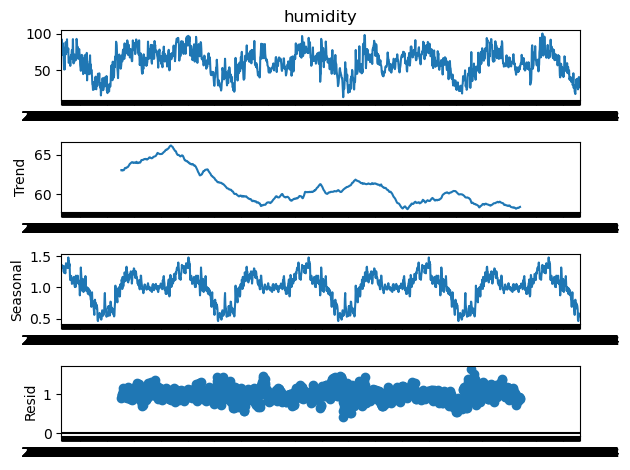

In [20]:
decompose_result.plot();

In [21]:
# Perform additive decomposition on the 'humidity' column on yearly basis
decompose_result = seasonal_decompose(weather['humidity'], model='additive',  period= 365)

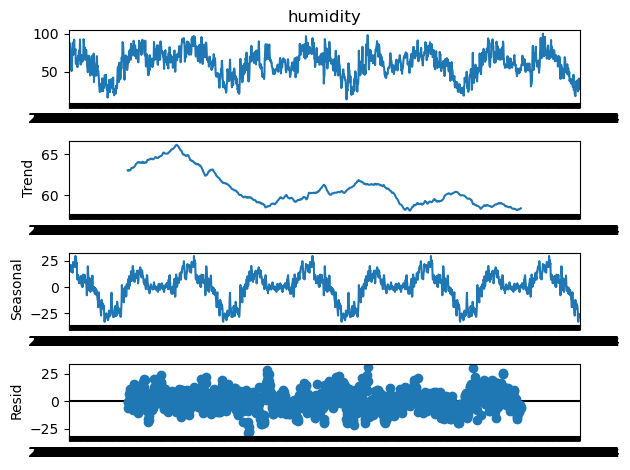

In [22]:
decompose_result.plot();

#### Observations
* The additive & multiplicative decomposition on the 'humidity' column on yearly basis has been plotted.
* In both of the decomposition, original graph, the trend, seasonal and the resid or the error can be seen.
* Seasonality is unchanged throughout these two graphs.
* Trend has the downward tendency.
* Resid is thicker for the additive decomposotion, compared to the multiplicative decomposition.

## Part II - Fit various smoothing models to existing data

## Moving Averages

### SMA - Simple Moving Averages

In [23]:
weather.dropna(inplace=True) #missing value treatment

In [24]:
weather['6-month-SMA humidity'] = weather['humidity'].rolling(window=6).mean()

In [25]:
weather['12-month-SMA humidity'] = weather['humidity'].rolling(window=12).mean()

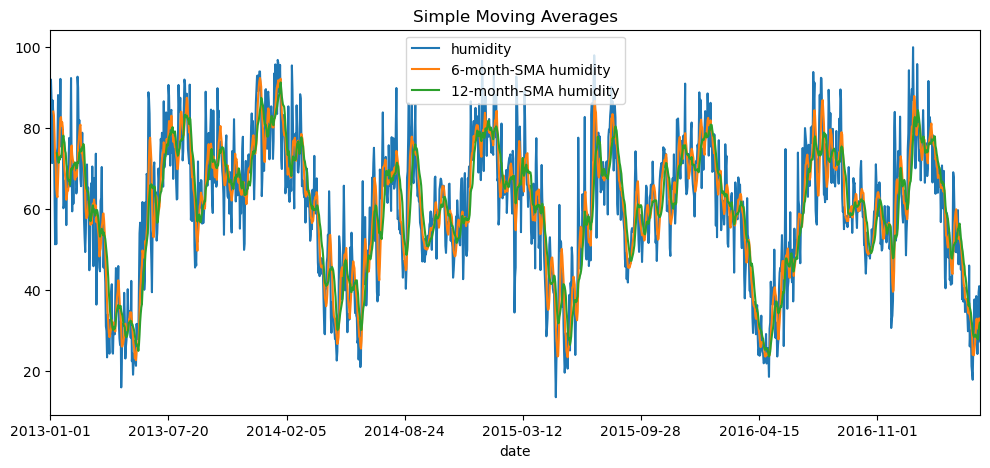

In [26]:
#6-month-SMA humidity & 12-month-SMA humidity plot 
weather[['humidity', '6-month-SMA humidity', '12-month-SMA humidity']].plot(figsize=(12,5), title='Simple Moving Averages').autoscale(axis='x',tight=True)

In [27]:
weather.head(12)

,meantemp,humidity,wind_speed,meanpressure,meantemp_trend,meantemp_cycles,6-month-SMA humidity,12-month-SMA humidity
date,,,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,7.786509,2.213491,NaN,NaN
2013-01-02,7.400000,92.000000,2.980000,1017.800000,8.165925,-0.765925,NaN,NaN
2013-01-03,7.166667,87.000000,4.633333,1018.666667,8.546724,-1.380057,NaN,NaN
2013-01-04,8.666667,71.333333,1.233333,1017.166667,8.929811,-0.263144,NaN,NaN
2013-01-05,6.000000,86.833333,3.700000,1016.500000,9.315228,-3.315228,NaN,NaN
2013-01-06,7.000000,82.800000,1.480000,1018.000000,9.702854,-2.702854,84.077778,NaN
2013-01-07,7.000000,78.600000,6.300000,1020.000000,10.090494,-3.090494,83.094444,NaN
2013-01-08,8.857143,63.714286,7.142857,1018.714286,10.474263,-1.617120,78.380159,NaN
2013-01-09,14.000000,51.250000,12.500000,1017.000000,10.848348,3.151652,72.421825,NaN


#### Observations
Note that rolling introduces the NaN depending on the window size selected. However there are some disadvantages of simple moving average.
* Smaller windows will lead to more noise, rather than signal
* It will always lag by the size of the window (see the MA starts after a certain lag above in the figure)
* It will never reach to full peak or valley of the data due to the averaging.
* Does not really inform you about possible future behavior, all it really does is describe trends in your data.
* Extreme historical values can skew your SMA significantly

To help fix some of these problems, we have the EWMA or the Exponentially Weighted Moving Average

### EWMA - Exponentially Weighted Moving Average

EWMA alows to reduce the lag by putting more weight to the recent readings or values. The amount of weight applied is dependent on the actual parameters in the EWMA and the number of periods given in a window size.

Note that EWMA applies Single Exponential Smoothing

In [28]:
weather['ewma12 humidity'] = weather['humidity'].ewm(span=12,adjust=False).mean()

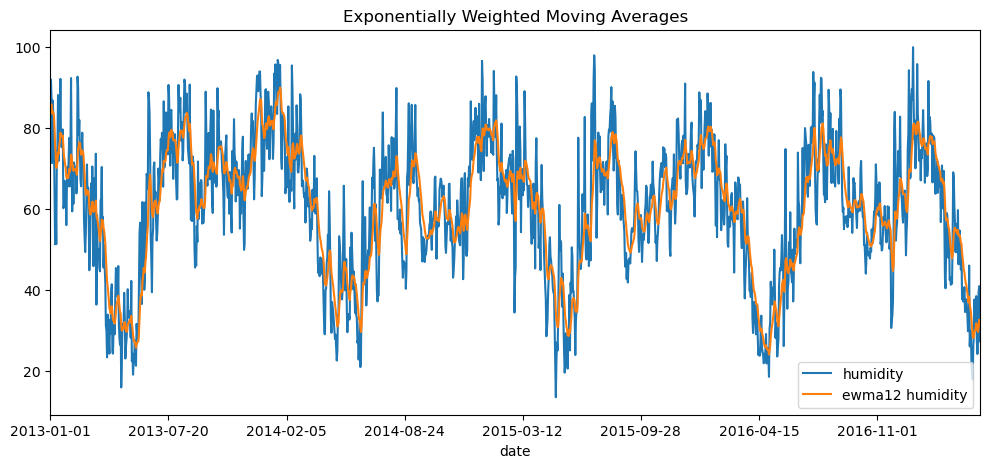

In [29]:
#12-month ewma humidity plot with mean temperature
weather[['humidity', 'ewma12 humidity']].plot(figsize=(12,5), title='Exponentially Weighted Moving Averages').autoscale(axis='x',tight=True)

### Comparing SMA to EWMA

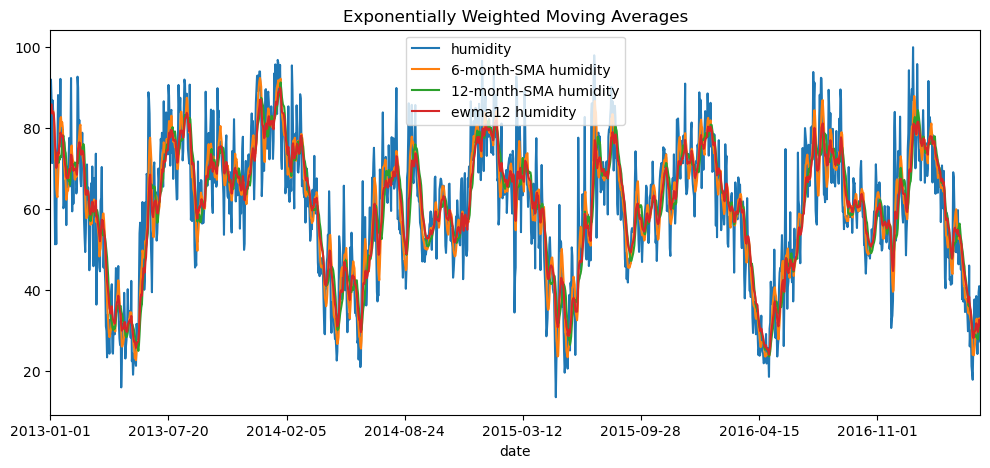

In [30]:
#12-month ewma humidity plot with mean temperature
weather[['humidity', '6-month-SMA humidity', '12-month-SMA humidity', 'ewma12 humidity']].plot(figsize=(12,5), title='Exponentially Weighted Moving Averages').autoscale(axis='x',tight=True)

#### Observations
* 6-month-Simple Moving Average, 12-month-Simple Moving Averag &  12-month Exponentially Weighted Moving Average all have similar trends.
* 12-month-Simple Moving Average is slightly flatter than 6-month-Simple Moving Average. 

### Holt Winters - Simple, Double and Triple Exponential Smoothing

Moving Averages and Single Exponential Smoothing does a poor job of forecasting when there is trend and seasonality in the data. Double and Triple exponential smoothing is best suited for this kind of timeseries data.Holt winters has all the three variations - Single, Double and Triple exponential smoothing.

Double Exponential smoothing uses a smoothing factor that addresses trend. Triple Exponential smoothing uses a smoothing factor that addresses seasonality.

Span corresponds to what is commonly called an “N-day EW moving average”.Alpha specifies the smoothing factor directly.

In [31]:
# set the span and the smoothing factor alpha
span = 12
alpha = 2/(span+1)

In [32]:
weather.columns

Index(['meantemp', 'humidity', 'wind_speed', 'meanpressure', 'meantemp_trend',
       'meantemp_cycles', '6-month-SMA humidity', '12-month-SMA humidity',
       'ewma12 humidity'],
      dtype='object')

To work with forecasting models like Holt Winters, ARIMA, SARIMA etc., the datetime index frequency needs to be set. The Airline passenger dataset index indicates dates on the start of the month. Hence we can set this as 'MS'

In [33]:
# Convert the index to a DatetimeIndex 
weather.index = pd.to_datetime(weather.index) 

In [34]:
#Identify and Handle Duplicate Timestamps:
duplicates = weather.index.duplicated(keep='first')
print(weather[duplicates]) 

             meantemp   humidity  wind_speed  meanpressure  meantemp_trend  \
date                                                                         
2017-01-01  15.913043  85.869565    2.743478          59.0       15.607768   

            meantemp_cycles  6-month-SMA humidity  12-month-SMA humidity  \
date                                                                       
2017-01-01         0.305275             86.406142              80.528125   

            ewma12 humidity  
date                         
2017-01-01        81.124381  


In [35]:
#for duplicate value treatment
weather = weather.groupby(weather.index).mean()

In [36]:
# Change the frequency to 'MS' (Monthly start)
weather = weather.asfreq('MS')  

In [37]:
weather.index.freq = 'MS'

In [38]:
weather.head()

,meantemp,humidity,wind_speed,meanpressure,meantemp_trend,meantemp_cycles,6-month-SMA humidity,12-month-SMA humidity,ewma12 humidity
date,,,,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,7.786509,2.213491,NaN,NaN,84.500000
2013-02-01,16.000000,73.000000,2.220000,1016.000000,15.098405,0.901595,66.016667,67.063889,68.464365
2013-03-01,17.333333,49.333333,24.066667,1016.333333,19.588537,-2.255204,63.520437,68.667063,65.330557
2013-04-01,25.375000,45.500000,4.400000,1008.500000,25.536616,-0.161616,58.889881,54.252976,55.312106
2013-05-01,31.857143,15.857143,12.685714,1002.833333,31.262506,0.594636,29.922619,34.725198,31.308548


In [39]:
weather.index

DatetimeIndex(['2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01',
               '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01'],
              dtype='datetime64[ns]', name='date', freq='MS')

### Simple Exponential Smoothing - Using Holt Winters
This is same as ewm method in Pandas

In [40]:
# Simple Exponential Smoothing on humidity
weather['SES12 humidity'] = SimpleExpSmoothing(weather['humidity']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)

shift(-1): This shifts the fitted values one step ahead in time. This is often done because the SES method calculates the smoothed value for the current period, and shifting it by one step aligns it with the original data for comparison or further analysis.

In [41]:
weather.head()

,meantemp,humidity,wind_speed,meanpressure,meantemp_trend,meantemp_cycles,6-month-SMA humidity,12-month-SMA humidity,ewma12 humidity,SES12 humidity
date,,,,,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,7.786509,2.213491,NaN,NaN,84.500000,84.500000
2013-02-01,16.000000,73.000000,2.220000,1016.000000,15.098405,0.901595,66.016667,67.063889,68.464365,82.730769
2013-03-01,17.333333,49.333333,24.066667,1016.333333,19.588537,-2.255204,63.520437,68.667063,65.330557,77.592702
2013-04-01,25.375000,45.500000,4.400000,1008.500000,25.536616,-0.161616,58.889881,54.252976,55.312106,72.655363
2013-05-01,31.857143,15.857143,12.685714,1002.833333,31.262506,0.594636,29.922619,34.725198,31.308548,63.917176


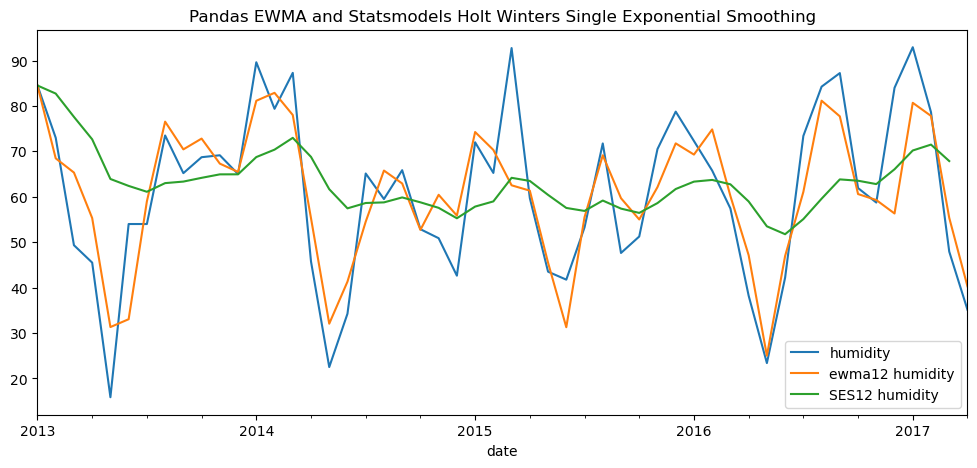

In [42]:
weather[['humidity','ewma12 humidity','SES12 humidity']].plot(figsize = (12,5), title='Pandas EWMA and Statsmodels Holt Winters Single Exponential Smoothing');

#### Observations
* Both the EWMA and Holt Winters Single Exponential Smoothing curve fit each other completely.

### Double Exponential Smoothing

In [43]:
# on additive trend
weather['DES12 humidity'] = ExponentialSmoothing(weather['humidity'],trend='add').fit().fittedvalues.shift(-1)

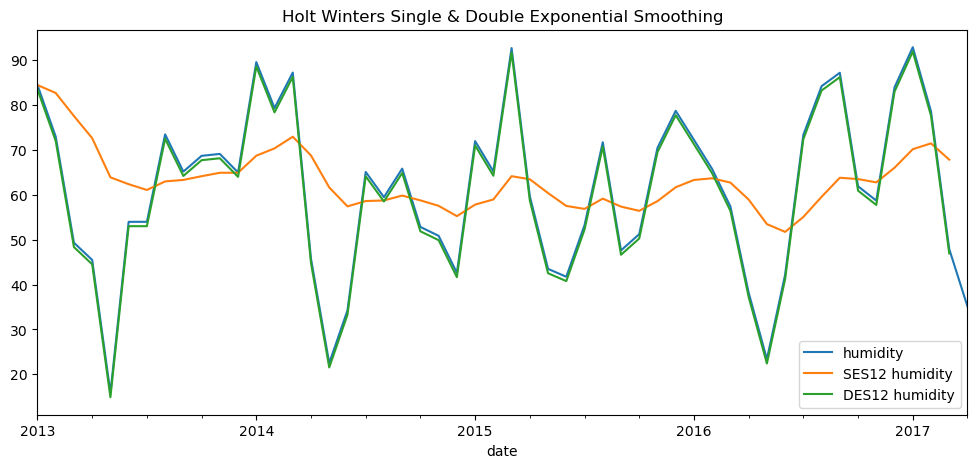

In [44]:
weather[['humidity','SES12 humidity','DES12 humidity']].plot(figsize = (12,5), title='Holt Winters Single & Double Exponential Smoothing');

Here the double exponential smoothing completely overlaps on the original data. Let's plot for the last 24 months.

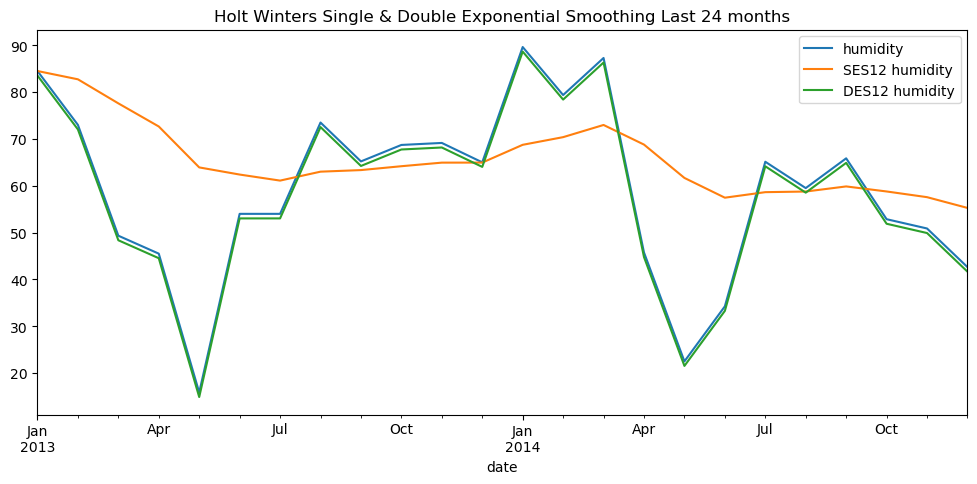

In [45]:
weather[['humidity','SES12 humidity','DES12 humidity']].iloc[:24].plot(figsize = (12,5), title='Holt Winters Single & Double Exponential Smoothing Last 24 months').autoscale(axis='x',tight=True);

Lets replot the above using the multiplicative adjustment instead of additive.

In [46]:
# on multiplicative trend
weather['DES12 humidity mul'] = ExponentialSmoothing(weather['humidity'],trend='mul').fit().fittedvalues.shift(-1)

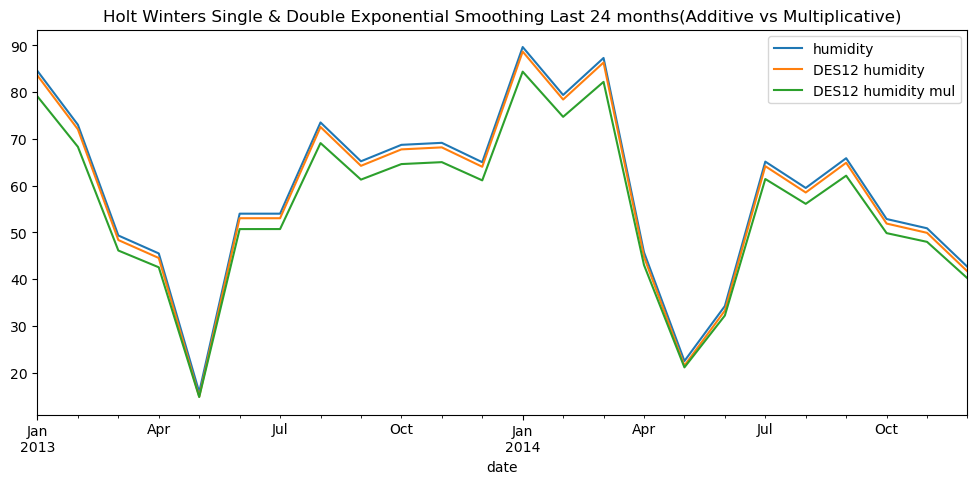

In [47]:
weather[['humidity','DES12 humidity', 'DES12 humidity mul']].iloc[:24].plot(figsize = (12,5), title='Holt Winters Single & Double Exponential Smoothing Last 24 months(Additive vs Multiplicative)').autoscale(axis='x',tight=True);

#### Observations
* Although minor, the multiplicative adjustment gives a better result compared to the additive adjustment for the trend.

### Triple Exponential Smoothing

In [48]:
#additive trend
weather['TESadd12'] = ExponentialSmoothing(weather['humidity'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues

In [49]:
weather.head()

,meantemp,humidity,wind_speed,meanpressure,meantemp_trend,meantemp_cycles,6-month-SMA humidity,12-month-SMA humidity,ewma12 humidity,SES12 humidity,DES12 humidity,DES12 humidity mul,TESadd12
date,,,,,,,,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,7.786509,2.213491,NaN,NaN,84.500000,84.500000,83.527097,79.058096,81.208958
2013-02-01,16.000000,73.000000,2.220000,1016.000000,15.098405,0.901595,66.016667,67.063889,68.464365,82.730769,72.027097,68.287293,71.287760
2013-03-01,17.333333,49.333333,24.066667,1016.333333,19.588537,-2.255204,63.520437,68.667063,65.330557,77.592702,48.360431,46.120546,65.853285
2013-04-01,25.375000,45.500000,4.400000,1008.500000,25.536616,-0.161616,58.889881,54.252976,55.312106,72.655363,44.527097,42.535606,43.803207
2013-05-01,31.857143,15.857143,12.685714,1002.833333,31.262506,0.594636,29.922619,34.725198,31.308548,63.917176,14.884240,14.803742,25.513443


In [50]:
#multiplicative trend
weather['TESmul12'] = ExponentialSmoothing(weather['humidity'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues

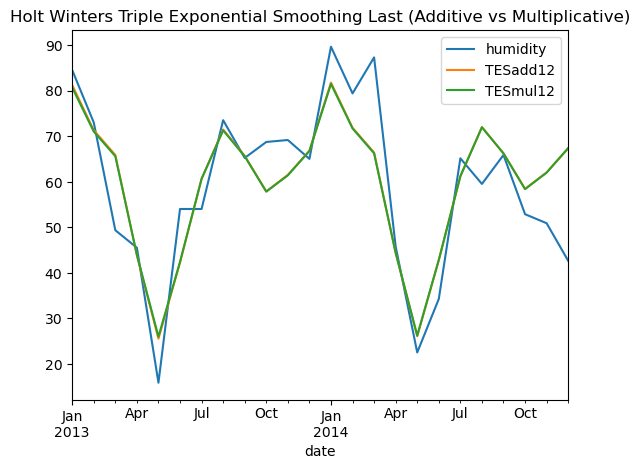

In [51]:
weather[['humidity','TESadd12','TESmul12']].iloc[:24].plot(title='Holt Winters Triple Exponential Smoothing Last (Additive vs Multiplicative)').autoscale(axis='x',tight=True);

#### Observations
* Multiplicative Triple Exponential smoothing gives a better result.

## Part III - Forecasting with Holt Winters Method

In [52]:
#reading the dataset again for fresh copy
weather1 = pd.read_csv("CSV Files/DailyDelhiClimateTrain.csv", parse_dates = True, low_memory = False, index_col='date')
weather2 = pd.read_csv("CSV Files/DailyDelhiClimateTest.csv", parse_dates = True, low_memory = False, index_col='date')
weather = pd.concat([weather1, weather2], axis = 0)

In [53]:
# Convert the index to a DatetimeIndex 
weather.index = pd.to_datetime(weather.index) 

In [54]:
#Identify and Handle Duplicate Timestamps:
duplicates = weather.index.duplicated(keep='first')
print(weather[duplicates]) 

             meantemp   humidity  wind_speed  meanpressure
date                                                      
2017-01-01  15.913043  85.869565    2.743478          59.0


In [55]:
#for duplicate value treatment
weather = weather.groupby(weather.index).mean()

In [56]:
# Change the frequency to 'MS' (Monthly start)
weather = weather.asfreq('MS')  

In [57]:
weather.index.freq = 'MS'

In [58]:
weather.index

DatetimeIndex(['2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01',
               '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01'],
              dtype='datetime64[ns]', name='date', freq='MS')

In [59]:
weather.tail()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2016-12-01,19.750000,84.000000,2.704167,1016.875000
2017-01-01,12.956522,92.934783,1.371739,537.500000
2017-02-01,15.250000,78.625000,5.100000,1017.500000
2017-03-01,24.461538,47.923077,6.415385,1012.923077
2017-04-01,31.375000,35.125000,9.037500,1005.000000


In [60]:
# Number of months of data 
len(weather)

52

### Split into training and test set

In [61]:
train_weather = weather[:39]['humidity']
test_weather = weather[39:]['humidity']

In [62]:
len(test_weather)

13

### Fit the model on the train set
Seasonal periods with value 12 indicates the seasonality we expect in the data. for weather humidity it can be safely assumed that the seasonality would repeat every 12 months.

In [63]:
fitted_model = ExponentialSmoothing(train_weather,trend='mul',seasonal='mul',seasonal_periods=12).fit()

In [64]:
test_predictions = fitted_model.forecast(13).rename('HW Test Forecast')

In [65]:
test_predictions[:10]

2016-04-01    48.330439
2016-05-01    26.077655
2016-06-01    41.760246
2016-07-01    55.277400
2016-08-01    65.666704
2016-09-01    57.405109
2016-10-01    55.526031
2016-11-01    61.081780
2016-12-01    59.677784
2017-01-01    75.941264
Freq: MS, Name: HW Test Forecast, dtype: float64

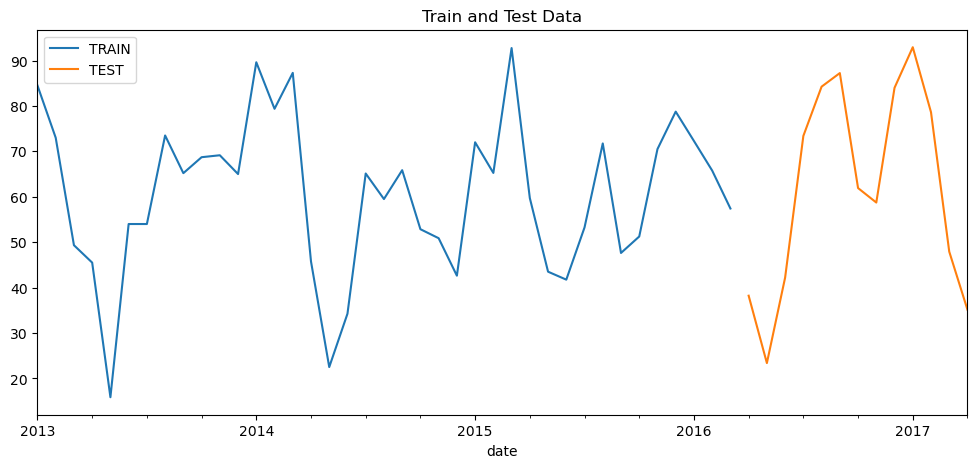

In [66]:
train_weather.plot(legend=True,label='TRAIN')
test_weather.plot(legend=True,label='TEST',figsize=(12,5))
plt.title('Train and Test Data');

Next we will plot also the predicted test data

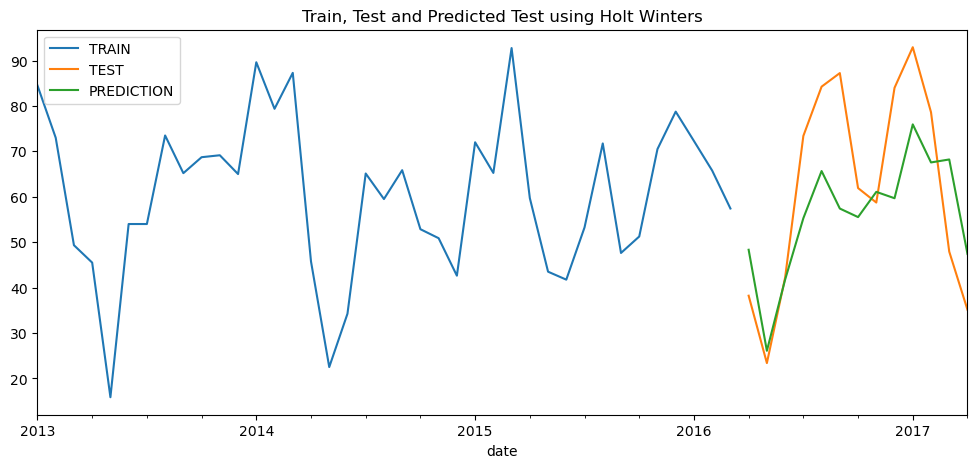

In [67]:
train_weather.plot(legend=True,label='TRAIN')
test_weather.plot(legend=True,label='TEST',figsize=(12,5))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters');

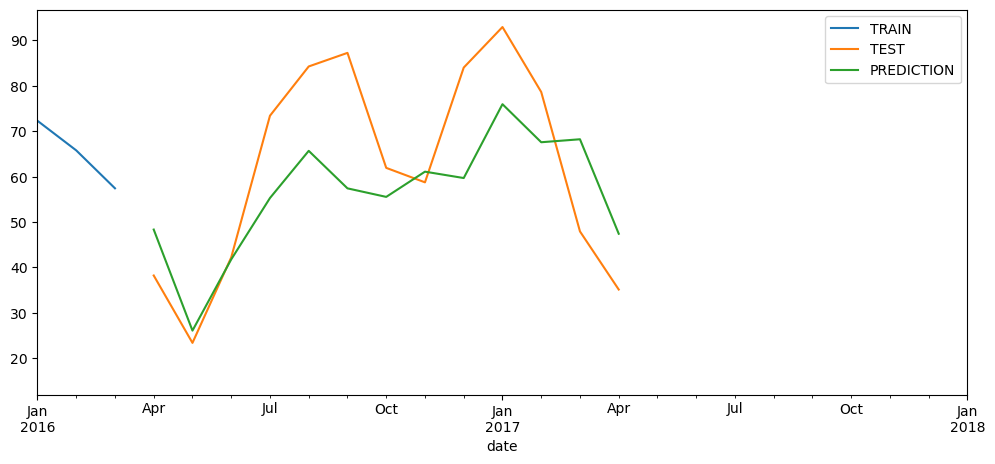

In [68]:
#Plot for the recent rows
train_weather.plot(legend=True,label='TRAIN')
test_weather.plot(legend=True,label='TEST',figsize=(12,5))
test_predictions.plot(legend=True,label='PREDICTION',xlim=['2016-01-01','2018-01-01']);

#### Observations
* Test & Prediction curves are almost similar.
* Train curve is good for the data.

### Evaluation metrics

In [69]:
print(f'Mean Absolute Error = {mean_absolute_error(test_weather,test_predictions)}')

Mean Absolute Error = 13.34613494370012


In [70]:
print(f'Mean Squared Error = {mean_squared_error(test_weather,test_predictions)}')

Mean Squared Error = 252.73902735406313


In [71]:
test_weather.describe()

count    13.000000
mean     62.148814
std      23.021647
min      23.375000
25%      42.200000
50%      61.916667
75%      84.000000
max      92.934783
Name: humidity, dtype: float64

#### Observations
* The Mean Absolute Error is very less compared to the mean of the true test data. 
* The Mean Squared Error is also not very large.
* The predictions are quite good till now.

### Forecast into the future

Till now, the test values are predicted & are compared with with the true test values. The true forecast can only be once it is done for the real future !!

In [72]:
final_model = ExponentialSmoothing(weather['humidity'], trend='mul',seasonal='mul',seasonal_periods=12).fit()

In [73]:
forecast_predictions = final_model.forecast(steps=36)

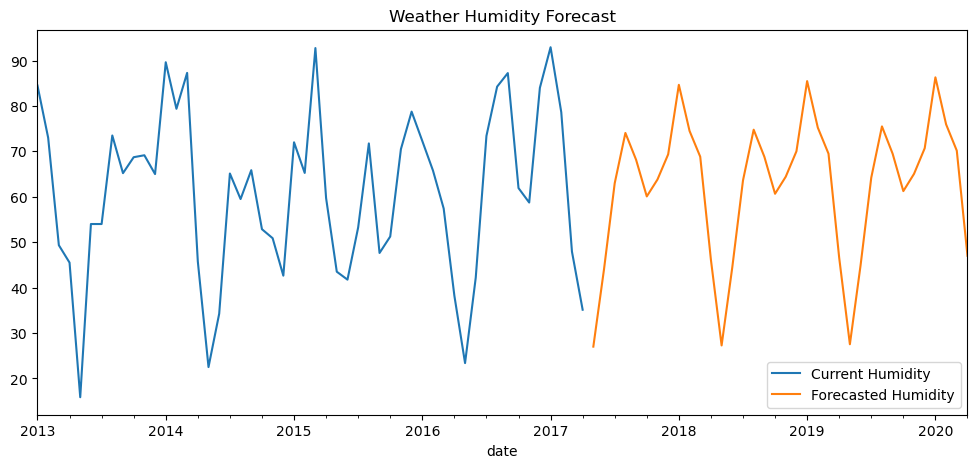

In [74]:
weather['humidity'].plot(figsize=(12,5),legend=True,label='Current Humidity')
forecast_predictions.plot(legend=True,label='Forecasted Humidity')
plt.title('Weather Humidity Forecast');

#### Observations
* From the curve, it seems that the Forcasted Humidity is in good relation with the Current Humidity.
* The forcast is quite good.

### Note
* There are many other considerations to be taken while modeling with time series data like lagging, stationarity etc.
* Reference to the theoretical part https://otexts.com/fpp2/stationarity.html